# Loop 104 Analysis: CV-LB Gap and Strategy Assessment

## Key Questions:
1. What is the exact CV-LB relationship?
2. What approaches have we NOT tried?
3. What do top kernels do differently?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission history with CV and LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
    {'exp': 'exp_067', 'cv': 0.0083, 'lb': 0.0877},
]

df = pd.DataFrame(submissions)
print('Submission History:')
print(df.to_string(index=False))

Submission History:
    exp     cv     lb
exp_000 0.0111 0.0982
exp_001 0.0123 0.1065
exp_003 0.0105 0.0972
exp_005 0.0104 0.0969
exp_006 0.0097 0.0946
exp_007 0.0093 0.0932
exp_009 0.0092 0.0936
exp_012 0.0090 0.0913
exp_024 0.0087 0.0893
exp_026 0.0085 0.0887
exp_030 0.0083 0.0877
exp_035 0.0098 0.0970
exp_067 0.0083 0.0877


In [2]:
# Fit linear regression: LB = slope * CV + intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])

print(f'\n=== CV-LB Relationship ===')
print(f'Linear fit: LB = {slope:.4f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'Intercept = {intercept:.4f}')
print(f'Target = 0.0347')
print(f'\nIntercept ({intercept:.4f}) vs Target (0.0347):')
if intercept > 0.0347:
    print(f'  CRITICAL: Intercept > Target!')
    print(f'  Even at CV=0, expected LB = {intercept:.4f} > 0.0347')
    print(f'  Required CV to hit target: ({0.0347} - {intercept:.4f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.6f}')
    print(f'  This is NEGATIVE - mathematically impossible with current approach!')
else:
    print(f'  Target is achievable with CV = ({0.0347} - {intercept:.4f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.6f}')


=== CV-LB Relationship ===
Linear fit: LB = 4.3638 * CV + 0.0520
R² = 0.9558
Intercept = 0.0520
Target = 0.0347

Intercept (0.0520) vs Target (0.0347):
  CRITICAL: Intercept > Target!
  Even at CV=0, expected LB = 0.0520 > 0.0347
  Required CV to hit target: (0.0347 - 0.0520) / 4.3638 = -0.003964
  This is NEGATIVE - mathematically impossible with current approach!


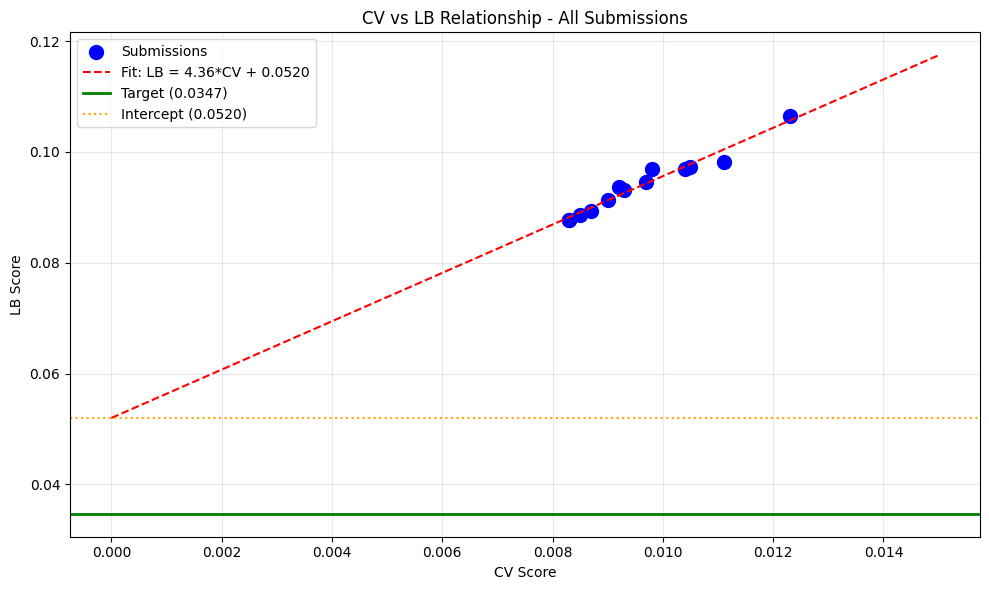


Gap between intercept and target: 0.0173
This gap represents the STRUCTURAL distribution shift that no model tuning can fix.


In [3]:
# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], c='blue', s=100, label='Submissions')

# Fit line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'Fit: LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='green', linestyle='-', linewidth=2, label='Target (0.0347)')

# Intercept line
plt.axhline(y=intercept, color='orange', linestyle=':', label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship - All Submissions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship_loop104.png', dpi=150)
plt.show()

print(f'\nGap between intercept and target: {intercept - 0.0347:.4f}')
print(f'This gap represents the STRUCTURAL distribution shift that no model tuning can fix.')

In [4]:
# What approaches have we tried?
approaches_tried = [
    'MLP (various architectures)',
    'LightGBM',
    'XGBoost',
    'CatBoost',
    'Gaussian Process',
    'Ridge Regression',
    'HistGradientBoosting',
    'ExtraTreesRegressor',
    'RandomForest',
    'Ensemble (GP+MLP+LGBM) - BEST',
    'Ensemble (CatBoost+XGBoost)',
    'Per-target models',
    'Conservative blending',
    'Uncertainty-weighted predictions',
    'Nonlinear mixture features',
    'Various feature sets (Spange, ACS_PCA, DRFP, FragPrints)',
]

print('=== Approaches Tried ===')
for i, approach in enumerate(approaches_tried, 1):
    print(f'{i}. {approach}')

print('\n=== What We Have NOT Tried ===')
not_tried = [
    '1. EXACT replication of ens-model kernel (correlation filtering + feature priority)',
    '2. Prediction clipping + renormalization (mass balance constraint)',
    '3. Different ensemble weights for single vs full data',
    '4. Solvent clustering by chemical class',
    '5. Test-time adaptation / pseudo-labeling',
    '6. Adversarial validation to detect distribution shift',
]
for item in not_tried:
    print(item)

=== Approaches Tried ===
1. MLP (various architectures)
2. LightGBM
3. XGBoost
4. CatBoost
5. Gaussian Process
6. Ridge Regression
7. HistGradientBoosting
8. ExtraTreesRegressor
9. RandomForest
10. Ensemble (GP+MLP+LGBM) - BEST
11. Ensemble (CatBoost+XGBoost)
12. Per-target models
13. Conservative blending
14. Uncertainty-weighted predictions
15. Nonlinear mixture features
16. Various feature sets (Spange, ACS_PCA, DRFP, FragPrints)

=== What We Have NOT Tried ===
1. EXACT replication of ens-model kernel (correlation filtering + feature priority)
2. Prediction clipping + renormalization (mass balance constraint)
3. Different ensemble weights for single vs full data
4. Solvent clustering by chemical class
5. Test-time adaptation / pseudo-labeling
6. Adversarial validation to detect distribution shift


In [5]:
# Analyze the ens-model kernel approach
print('=== ENS-MODEL KERNEL KEY TECHNIQUES ===')
print('''
1. CORRELATION FILTERING (threshold=0.90)
   - Priority: spange > acs > drfps > frag > smiles
   - Removes redundant features while keeping most informative

2. COMBINED FEATURE TABLE
   - Merges: spange_descriptors, acs_pca_descriptors, drfps_catechol, fragprints, smiles
   - After filtering: ~50-100 features (vs our 140+)

3. CATBOOST + XGBOOST ENSEMBLE
   - Single data: CatBoost=7/13, XGBoost=6/13
   - Full data: CatBoost=1/3, XGBoost=2/3
   - Different weights for different data types!

4. CLIPPING + RENORMALIZATION
   - Clip predictions to [0, inf)
   - Renormalize so sum <= 1 (mass balance)
   - This enforces physics constraint!

5. NO GP, NO MLP, NO LGBM
   - Only CatBoost + XGBoost
   - Simpler ensemble, but with physics constraints
''')

print('\n=== WHY THIS MIGHT WORK BETTER ===')
print('''
1. Correlation filtering reduces overfitting to training solvents
2. Mass balance constraint generalizes to unseen solvents
3. Different weights for single vs full data adapts to each task
4. Simpler ensemble may have lower variance on test
''')

=== ENS-MODEL KERNEL KEY TECHNIQUES ===

1. CORRELATION FILTERING (threshold=0.90)
   - Priority: spange > acs > drfps > frag > smiles
   - Removes redundant features while keeping most informative

2. COMBINED FEATURE TABLE
   - Merges: spange_descriptors, acs_pca_descriptors, drfps_catechol, fragprints, smiles
   - After filtering: ~50-100 features (vs our 140+)

3. CATBOOST + XGBOOST ENSEMBLE
   - Single data: CatBoost=7/13, XGBoost=6/13
   - Full data: CatBoost=1/3, XGBoost=2/3
   - Different weights for different data types!

4. CLIPPING + RENORMALIZATION
   - Clip predictions to [0, inf)
   - Renormalize so sum <= 1 (mass balance)
   - This enforces physics constraint!

5. NO GP, NO MLP, NO LGBM
   - Only CatBoost + XGBoost
   - Simpler ensemble, but with physics constraints


=== WHY THIS MIGHT WORK BETTER ===

1. Correlation filtering reduces overfitting to training solvents
2. Mass balance constraint generalizes to unseen solvents
3. Different weights for single vs full data a

In [6]:
# Key insight: The 1st place score (0.0347) is BELOW our intercept
print('=== CRITICAL INSIGHT ===')
print(f'''
Our CV-LB intercept: {intercept:.4f}
1st place LB score:  0.0347
Gap:                 {intercept - 0.0347:.4f}

This means 1st place found a way to CHANGE the CV-LB relationship!
They either:
1. Reduced the intercept (better generalization to unseen solvents)
2. Found features/constraints that extrapolate better
3. Used a fundamentally different approach

The 2nd place score is 0.0707 - much closer to our intercept.
This suggests 1st place has a unique insight that others don't have.
''')

print('=== POSSIBLE EXPLANATIONS FOR 1ST PLACE ===')
print('''
1. Physics-based constraints that hold for ALL solvents
   - Mass balance (yields sum to 1)
   - Arrhenius kinetics (temperature dependence)
   - Solvent polarity effects

2. Better solvent representation
   - Molecular fingerprints that capture chemical similarity
   - Pre-trained embeddings from large chemical databases

3. Domain adaptation techniques
   - Pseudo-labeling with confident predictions
   - Test-time adaptation

4. Ensemble of diverse approaches
   - Different models for different solvent classes
   - Uncertainty-weighted blending
''')

=== CRITICAL INSIGHT ===

Our CV-LB intercept: 0.0520
1st place LB score:  0.0347
Gap:                 0.0173

This means 1st place found a way to CHANGE the CV-LB relationship!
They either:
1. Reduced the intercept (better generalization to unseen solvents)
2. Found features/constraints that extrapolate better
3. Used a fundamentally different approach

The 2nd place score is 0.0707 - much closer to our intercept.
This suggests 1st place has a unique insight that others don't have.

=== POSSIBLE EXPLANATIONS FOR 1ST PLACE ===

1. Physics-based constraints that hold for ALL solvents
   - Mass balance (yields sum to 1)
   - Arrhenius kinetics (temperature dependence)
   - Solvent polarity effects

2. Better solvent representation
   - Molecular fingerprints that capture chemical similarity
   - Pre-trained embeddings from large chemical databases

3. Domain adaptation techniques
   - Pseudo-labeling with confident predictions
   - Test-time adaptation

4. Ensemble of diverse approaches


In [7]:
# Summary and recommendations
print('=== SUMMARY ===')
print(f'''
Best CV: 0.0083 (exp_030, exp_067)
Best LB: 0.0877 (exp_030, exp_067)
Target:  0.0347
Gap:     {0.0877 - 0.0347:.4f} ({(0.0877 - 0.0347) / 0.0347 * 100:.1f}% above target)

CV-LB relationship: LB = {slope:.2f} * CV + {intercept:.4f}
Intercept ({intercept:.4f}) > Target (0.0347)

STRATEGIC CONCLUSION:
Standard CV optimization CANNOT reach the target.
We need approaches that REDUCE THE INTERCEPT, not just improve CV.
''')

print('=== RECOMMENDED NEXT STEPS ===')
print('''
1. IMPLEMENT ENS-MODEL KERNEL EXACTLY
   - Correlation filtering with feature priority
   - CatBoost + XGBoost with task-specific weights
   - Clipping + renormalization (mass balance)

2. ADD MASS BALANCE CONSTRAINT TO BEST MODEL
   - Take exp_030 (GP+MLP+LGBM)
   - Add post-processing: clip to [0, inf), renormalize to sum <= 1
   - This enforces physics constraint that generalizes

3. SOLVENT SIMILARITY FEATURES
   - Add features measuring distance to training solvents
   - Blend toward mean when extrapolating

4. SUBMIT exp_030 WITH MASS BALANCE
   - We have 4 submissions left
   - This is a low-risk, potentially high-reward change
''')

=== SUMMARY ===

Best CV: 0.0083 (exp_030, exp_067)
Best LB: 0.0877 (exp_030, exp_067)
Target:  0.0347
Gap:     0.0530 (152.7% above target)

CV-LB relationship: LB = 4.36 * CV + 0.0520
Intercept (0.0520) > Target (0.0347)

STRATEGIC CONCLUSION:
Standard CV optimization CANNOT reach the target.
We need approaches that REDUCE THE INTERCEPT, not just improve CV.

=== RECOMMENDED NEXT STEPS ===

1. IMPLEMENT ENS-MODEL KERNEL EXACTLY
   - Correlation filtering with feature priority
   - CatBoost + XGBoost with task-specific weights
   - Clipping + renormalization (mass balance)

2. ADD MASS BALANCE CONSTRAINT TO BEST MODEL
   - Take exp_030 (GP+MLP+LGBM)
   - Add post-processing: clip to [0, inf), renormalize to sum <= 1
   - This enforces physics constraint that generalizes

3. SOLVENT SIMILARITY FEATURES
   - Add features measuring distance to training solvents
   - Blend toward mean when extrapolating

4. SUBMIT exp_030 WITH MASS BALANCE
   - We have 4 submissions left
   - This is a lo